**Dataset Link:** https://zenodo.org/record/2545611#.ZDJmdHZBy71 <br />
**Reference Paper:** https://doi.org/10.1016/j.ecoinf.2022.101633

## Augmenting Imbalanced Class Image

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os, random
from torchvision.utils import save_image

# Define the path to your train folder containing class folders
train_folder = './data/balanced_wood_species/Test'

# Define the transformations you want to apply to your images
blur_transformation = transforms.Compose([
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])
sharpen_transformation = transforms.Compose([
    transforms.RandomAdjustSharpness(sharpness_factor=1.25, p=1.0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])


# Define a custom dataset class to load and transform your images
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.class_folders = sorted(os.listdir(folder_path))

    def __len__(self):
        total_instances = 0
        for class_folder in self.class_folders:
            class_path = os.path.join(self.folder_path, class_folder)
            total_instances += len(os.listdir(class_path))
        return total_instances

    def __getitem__(self, index):
        class_folder_index = 0
        instance_index = index

        # Find the corresponding class folder and instance index
        for i, class_folder in enumerate(self.class_folders):
            class_path = os.path.join(self.folder_path, class_folder)
            if instance_index < len(os.listdir(class_path)):
                class_folder_index = i
                break
            else:
                instance_index -= len(os.listdir(class_path))

        # Load and transform the image
        class_folder = self.class_folders[class_folder_index]
        instance_path = os.path.join(self.folder_path, class_folder, os.listdir(os.path.join(self.folder_path, class_folder))[instance_index])
        image = Image.open(instance_path)
        if self.transform is not None:
            image = self.transform(image)

        return image, class_folder_index

# Define a function to balance your class folders by creating new images using image augmentation
def balance_class_folders(dataset):
    # Calculate the maximum number of instances in any class folder
    max_instances = max([len(os.listdir(os.path.join(train_folder, class_folder))) for class_folder in dataset.class_folders])

    # Loop through each class folder and create new images using image augmentation
    for class_folder in dataset.class_folders:
        class_path = os.path.join(train_folder, class_folder)
        instances = os.listdir(class_path)
        num_instances = len(instances)
        num_new_instances = max_instances - num_instances

        # Create new images using image augmentation until the class folder is balanced
        for i in range(num_new_instances):
            instance_path = os.path.join(class_path, instances[i % num_instances])
            image = Image.open(instance_path)
            # Randomly select a task to perform
            if random.random() < 0.5:
                print(i, "  BLUR")
                image = blur_transformation(image)
            else:
                print(i, "  SHARPEN")
                image = sharpen_transformation(image)
            new_instance_path = os.path.join(class_path, f'augmented_{num_instances + i}.jpg')
            save_image(image, new_instance_path)

# Load the dataset and balance the class folders
dataset = CustomDataset(train_folder)
balance_class_folders(dataset)


# Implementation

In [2]:
import torch
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, sampler

from my_utils import *
import os, PIL

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
sn.set_style("darkgrid")
sn.set_palette("dark")
#######################################################################
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device");
#######################################################################
CLASS_LABEL_MAPPING = {
    '1': "European Beech",
    '2': "Walnut",
    '3': "Sweet Chestnut",
    '4': "Turkey Oak",
    '5': "Alder",
    '6': "Manna Ash",
    '7': "Norway Spruce",
    '8': "Scots Pine",
    '9': "Tree-of-Heaven",
    '10': "Black Locust",
    '11': "Mediterranean Cypress",
    '12': "Old World Sycamore",
}

class WoodDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.transform = transform
        self.class_mapping = {}
        self.data = []
        for i, cl in enumerate(os.listdir(data_dir)):
            self.class_mapping[i] = CLASS_LABEL_MAPPING[str(cl)]
            for file in os.listdir(f'{data_dir}/{cl}'):
                self.data += [(f'{data_dir}/{cl}/{file}', i)]
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        assert index >= 0
        assert index < len(self.data)
        f, cl = self.data[index]
        img = PIL.Image.open(f).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, cl, f

    def classes(self):
        return list(set(cl for f, cl in self.data))
    
    def get_class(self, index):
        assert index >= 0
        assert index < len(self.data)
        f, cl = self.data[index]
        return cl
#######################################################################

Using cuda device


In [25]:
mean, std, size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224    # SE-ResNeXT
# mean, std, size = (0.5,), (0.5,), 299                                # Inception & Xception & NASNet-A-Mobile

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=size, scale=(0.8, 1.0)),     
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std =std)
    ])

val_transform =  transforms.Compose([
        transforms.Resize(size=size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std =std)
    ])

def train_trans(img):
    img = train_transform(img)
    return img

def val_trans(img):
    img = val_transform(img)
    return img

In [26]:
NUM_CLASS = 12

# BATCH_SIZE = 64
# train_data_dir = "./data/balanced_wood_species/Train"

BATCH_SIZE = 32
train_data_dir = "./data/wood_species/Train"
test_data_dir = "./data/wood_species/Test"

train_data = WoodDataset(train_data_dir, train_trans)
test_data = WoodDataset(test_data_dir, val_trans)

train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


## EDA

In [5]:
train_data.class_mapping

{0: 'Turkey Oak',
 1: 'Black Locust',
 2: 'Norway Spruce',
 3: 'Mediterranean Cypress',
 4: 'European Beech',
 5: 'Alder',
 6: 'Old World Sycamore',
 7: 'Tree-of-Heaven',
 8: 'Sweet Chestnut',
 9: 'Scots Pine',
 10: 'Manna Ash',
 11: 'Walnut'}

In [6]:
### TRAIN SET ###
np_train = np.array(train_data.data)
unique, counts = np.unique(np_train[:, 1], return_counts=True)
sorted_indices = np.argsort(-counts)
unique = unique[sorted_indices]
counts = counts[sorted_indices]
print("Class    : ", unique)
print("Instance : ", counts)

Class    :  ['8' '4' '3' '6' '5' '1' '10' '0' '2' '7' '9' '11']
Instance :  [1024  936  552  504  464  440  432  400  308  224  224  205]


In [7]:
### TEST SET ###
np_test = np.array(test_data.data)
unique, counts = np.unique(np_test[:, 1], return_counts=True)
sorted_indices = np.argsort(-counts)
unique = unique[sorted_indices]
counts = counts[sorted_indices]
print("Class    : ", unique)
print("Instance : ", counts)

Class    :  ['8' '4' '3' '6' '5' '1' '10' '0' '2' '7' '9' '11']
Instance :  [508 468 276 252 232 220 216 200 152 108 108  96]


## Plot Some Sample Images

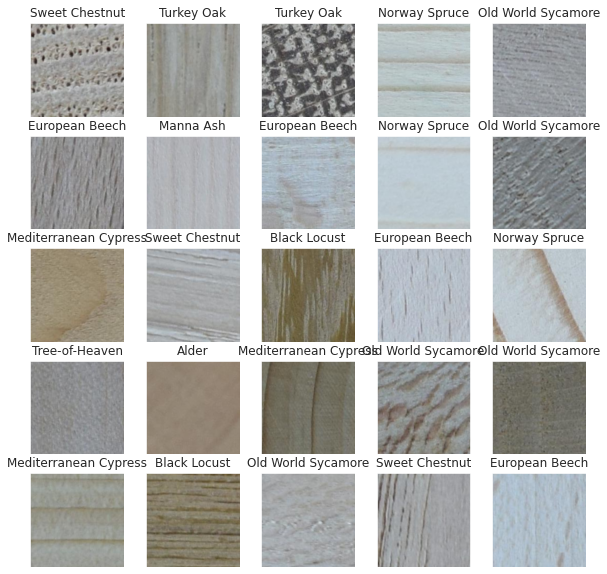

In [47]:
## Denormalize the Image Tensors
denorm = transforms.Normalize(
    mean = (-np.array(mean)/np.array(std)),
    std = (np.ones_like(std) / np.array(std))
)

for x_b, y_b, _ in train_dl:
    fig=plt.figure(figsize=(10, 10))
    rows, columns = 5, 5
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(denorm(x_b[i-1]).T)
        plt.xticks([])
        plt.yticks([])
        plt.title(test_data.class_mapping[y_b[i-1].item()])
    plt.show()
    break

# Pretrained Models

In [6]:
import pretrainedmodels   # https://modelzoo.co/model/pretrained-modelspytorch
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


# DenseNet-201 (Imbalanced)

In [7]:
print(pretrainedmodels.pretrained_settings['densenet201'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/densenet201-5750cbb1e.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'num_classes': 1000}}


In [8]:
denseNet = pretrainedmodels.__dict__["densenet201"](num_classes=1000, pretrained='imagenet')

# Freeze the parameters of the model
for param in denseNet.parameters():
    param.requires_grad = False
    
# Replace the last fully connected layer with a new one
denseNet.last_linear = nn.Linear(1920, NUM_CLASS)

denseNet = denseNet.to(device)

### Train 10 Epochs & Save the Model

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(denseNet.last_linear.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-05)

denseNet.train()

fit2(denseNet,
    train_dl,
    optimizer,
    criterion,
    epochs=10,
    device=device,
    save=True,
    save_name="DenseNet",
    logits = False
    )

=== (Save Results Mode : ON) ===

---------------------------
>>>>> Training Starts <<<<<
---------------------------

[Epoch: 1 | Batch:    64] loss: 1.391
[Epoch: 1 | Batch:   128] loss: 0.667
=== (Time/Epoch : 0.83 minutes) ===
[Epoch: 2 | Batch:    64] loss: 0.513
[Epoch: 2 | Batch:   128] loss: 0.444
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 3 | Batch:    64] loss: 0.370
[Epoch: 3 | Batch:   128] loss: 0.412
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 4 | Batch:    64] loss: 0.339
[Epoch: 4 | Batch:   128] loss: 0.364
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 5 | Batch:    64] loss: 0.392
[Epoch: 5 | Batch:   128] loss: 0.360
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 6 | Batch:    64] loss: 0.344
[Epoch: 6 | Batch:   128] loss: 0.373
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 7 | Batch:    64] loss: 0.306
[Epoch: 7 | Batch:   128] loss: 0.349
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 8 | Batch:    64] loss: 0.326
[Epoch: 8 | Batch:   128] loss: 0.380
=== (Time/Epoch : 0.5

### Load the previously saved model & Train 10 more (Total 20)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(denseNet.last_linear.parameters(), lr=0.0006, betas=(0.9, 0.999), eps=1e-08, weight_decay=4e-05)

checkpoint = torch.load('./check_points/DenseNet/BatchSize32/epoch_10.pt')
denseNet.load_state_dict(checkpoint['model_state_dict'])

denseNet.train()

fit2(denseNet,
    train_dl,
    optimizer,
    criterion,
    epochs=10,
    device=device,
    save=True,
    save_name="DenseNet",
    logits = False
    )

=== (Save Results Mode : ON) ===

---------------------------
>>>>> Training Starts <<<<<
---------------------------

[Epoch: 1 | Batch:    64] loss: 0.237
[Epoch: 1 | Batch:   128] loss: 0.215
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 2 | Batch:    64] loss: 0.205
[Epoch: 2 | Batch:   128] loss: 0.209
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 3 | Batch:    64] loss: 0.213
[Epoch: 3 | Batch:   128] loss: 0.236
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 4 | Batch:    64] loss: 0.206
[Epoch: 4 | Batch:   128] loss: 0.188
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 5 | Batch:    64] loss: 0.234
[Epoch: 5 | Batch:   128] loss: 0.191
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 6 | Batch:    64] loss: 0.183
[Epoch: 6 | Batch:   128] loss: 0.206
=== (Time/Epoch : 0.60 minutes) ===
[Epoch: 7 | Batch:    64] loss: 0.181
[Epoch: 7 | Batch:   128] loss: 0.139
=== (Time/Epoch : 0.64 minutes) ===
[Epoch: 8 | Batch:    64] loss: 0.227
[Epoch: 8 | Batch:   128] loss: 0.196
=== (Time/Epoch : 0.5

### Load the previously saved model & Train 10 more (Total 30)

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(denseNet.last_linear.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-04)

checkpoint = torch.load('./check_points/DenseNet/BatchSize32/epoch_20.pt')
denseNet.load_state_dict(checkpoint['model_state_dict'])

denseNet.train()

fit2(denseNet,
    train_dl,
    optimizer,
    criterion,
    epochs=10,
    device=device,
    save=True,
    save_name="DenseNet",
    logits = False
    )

=== (Save Results Mode : ON) ===

---------------------------
>>>>> Training Starts <<<<<
---------------------------

[Epoch: 1 | Batch:    64] loss: 0.173
[Epoch: 1 | Batch:   128] loss: 0.162
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 2 | Batch:    64] loss: 0.165
[Epoch: 2 | Batch:   128] loss: 0.194
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 3 | Batch:    64] loss: 0.189
[Epoch: 3 | Batch:   128] loss: 0.176
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 4 | Batch:    64] loss: 0.188
[Epoch: 4 | Batch:   128] loss: 0.180
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 5 | Batch:    64] loss: 0.155
[Epoch: 5 | Batch:   128] loss: 0.182
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 6 | Batch:    64] loss: 0.174
[Epoch: 6 | Batch:   128] loss: 0.163
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 7 | Batch:    64] loss: 0.180
[Epoch: 7 | Batch:   128] loss: 0.175
=== (Time/Epoch : 0.56 minutes) ===
[Epoch: 8 | Batch:    64] loss: 0.177
[Epoch: 8 | Batch:   128] loss: 0.183
=== (Time/Epoch : 0.5

## Evaluation

#### Evaluate the 10 Epochs Model

In [28]:
criterion = nn.CrossEntropyLoss()
checkpoint = torch.load('./check_points/DenseNet/BatchSize32/epoch_10.pt')
denseNet.load_state_dict(checkpoint['model_state_dict'])

accs = []
for _ in range(5):
    _, acc = evaluate_model(denseNet, test_dl, criterion)
    accs.append(acc)

print(np.mean(accs))
print(np.max(accs))
print(np.min(accs))

0.8686095504278548
0.8690308988764045
0.868188202381134


#### Evaluate the 20 Epochs Model

In [30]:
#### Evaluate the 10 Epochs Modelcriterion = nn.CrossEntropyLoss()
checkpoint = torch.load('./check_points/DenseNet/BatchSize32/epoch_20.pt')
denseNet.load_state_dict(checkpoint['model_state_dict'])

accs = []
for _ in range(5):
    _, acc = evaluate_model(denseNet, test_dl, criterion)
    accs.append(acc)

print(np.mean(accs))
print(np.max(accs))
print(np.min(accs))

0.9208707864364882
0.920997191011236
0.9205758424287431


#### Evaluate the 30 Epochs Model

In [45]:
#### Evaluate the 10 Epochs Modelcriterion = nn.CrossEntropyLoss()
checkpoint = torch.load('./check_points/DenseNet/BatchSize32/epoch_30.pt')
denseNet.load_state_dict(checkpoint['model_state_dict'])

accs = []
for _ in range(5):
    _, acc = evaluate_model(denseNet, test_dl, criterion)
    accs.append(acc)

print(np.mean(accs))
print(np.max(accs))
print(np.min(accs))

0.9286516853932584
0.9288623594166188
0.9284410115038411


# DenseNet-201 (Balanced)

In [16]:
print(pretrainedmodels.pretrained_settings['densenet201'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/densenet201-5750cbb1e.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'num_classes': 1000}}


In [17]:
denseNet = pretrainedmodels.__dict__["densenet201"](num_classes=1000, pretrained='imagenet')

# Freeze the parameters of the model
for param in denseNet.parameters():
    param.requires_grad = False
    
# Replace the last fully connected layer with a new one
denseNet.last_linear = nn.Linear(1920, NUM_CLASS)

denseNet = denseNet.to(device)

## Train

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(denseNet.last_linear.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-05)

denseNet.train()

fit2(denseNet,
    train_dl,
    optimizer,
    criterion,
    epochs=10,
    device=device,
    save=True,
    save_name="DenseNet",
    logits = False
    )

=== (Save Results Mode : ON) ===

---------------------------
>>>>> Training Starts <<<<<
---------------------------

[Epoch: 1 | Batch:    64] loss: 1.037
[Epoch: 1 | Batch:   128] loss: 0.517
[Epoch: 1 | Batch:   192] loss: 0.481
=== (Time/Epoch : 3.47 minutes) ===
[Epoch: 2 | Batch:    64] loss: 0.362
[Epoch: 2 | Batch:   128] loss: 0.314
[Epoch: 2 | Batch:   192] loss: 0.319
=== (Time/Epoch : 1.43 minutes) ===
[Epoch: 3 | Batch:    64] loss: 0.302
[Epoch: 3 | Batch:   128] loss: 0.271
[Epoch: 3 | Batch:   192] loss: 0.281
=== (Time/Epoch : 1.18 minutes) ===
[Epoch: 4 | Batch:    64] loss: 0.259
[Epoch: 4 | Batch:   128] loss: 0.252
[Epoch: 4 | Batch:   192] loss: 0.275
=== (Time/Epoch : 1.18 minutes) ===
[Epoch: 5 | Batch:    64] loss: 0.259
[Epoch: 5 | Batch:   128] loss: 0.248
[Epoch: 5 | Batch:   192] loss: 0.247
=== (Time/Epoch : 1.18 minutes) ===
[Epoch: 6 | Batch:    64] loss: 0.235
[Epoch: 6 | Batch:   128] loss: 0.209
[Epoch: 6 | Batch:   192] loss: 0.270
=== (Time/Epoch :

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(denseNet.last_linear.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=4e-05)

checkpoint = torch.load('./check_points/DenseNet/Balanced/epoch_10.pt')
denseNet.load_state_dict(checkpoint['model_state_dict'])

denseNet.train()

fit2(denseNet,
    train_dl,
    optimizer,
    criterion,
    epochs=10,
    device=device,
    save=True,
    save_name="DenseNet",
    logits = False
    )

=== (Save Results Mode : ON) ===

---------------------------
>>>>> Training Starts <<<<<
---------------------------

[Epoch: 1 | Batch:    64] loss: 0.150
[Epoch: 1 | Batch:   128] loss: 0.146
[Epoch: 1 | Batch:   192] loss: 0.160
=== (Time/Epoch : 1.17 minutes) ===
[Epoch: 2 | Batch:    64] loss: 0.150
[Epoch: 2 | Batch:   128] loss: 0.159
[Epoch: 2 | Batch:   192] loss: 0.125
=== (Time/Epoch : 1.17 minutes) ===
[Epoch: 3 | Batch:    64] loss: 0.145
[Epoch: 3 | Batch:   128] loss: 0.132
[Epoch: 3 | Batch:   192] loss: 0.154
=== (Time/Epoch : 1.17 minutes) ===
[Epoch: 4 | Batch:    64] loss: 0.163
[Epoch: 4 | Batch:   128] loss: 0.136
[Epoch: 4 | Batch:   192] loss: 0.133
=== (Time/Epoch : 1.17 minutes) ===
[Epoch: 5 | Batch:    64] loss: 0.137
[Epoch: 5 | Batch:   128] loss: 0.124
[Epoch: 5 | Batch:   192] loss: 0.141
=== (Time/Epoch : 1.17 minutes) ===
[Epoch: 6 | Batch:    64] loss: 0.140
[Epoch: 6 | Batch:   128] loss: 0.149
[Epoch: 6 | Batch:   192] loss: 0.139
=== (Time/Epoch :

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(denseNet.last_linear.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-05)

checkpoint = torch.load('./check_points/DenseNet/Balanced/epoch_20.pt')
denseNet.load_state_dict(checkpoint['model_state_dict'])

denseNet.train()

fit2(denseNet,
    train_dl,
    optimizer,
    criterion,
    epochs=10,
    device=device,
    save=True,
    save_name="DenseNet",
    logits = False
    )

=== (Save Results Mode : ON) ===

---------------------------
>>>>> Training Starts <<<<<
---------------------------

[Epoch: 1 | Batch:    64] loss: 0.120
[Epoch: 1 | Batch:   128] loss: 0.133
[Epoch: 1 | Batch:   192] loss: 0.127
=== (Time/Epoch : 1.16 minutes) ===
[Epoch: 2 | Batch:    64] loss: 0.128
[Epoch: 2 | Batch:   128] loss: 0.128
[Epoch: 2 | Batch:   192] loss: 0.124
=== (Time/Epoch : 1.17 minutes) ===
[Epoch: 3 | Batch:    64] loss: 0.127
[Epoch: 3 | Batch:   128] loss: 0.115
[Epoch: 3 | Batch:   192] loss: 0.128
=== (Time/Epoch : 1.17 minutes) ===
[Epoch: 4 | Batch:    64] loss: 0.121
[Epoch: 4 | Batch:   128] loss: 0.128
[Epoch: 4 | Batch:   192] loss: 0.114
=== (Time/Epoch : 1.17 minutes) ===
[Epoch: 5 | Batch:    64] loss: 0.122
[Epoch: 5 | Batch:   128] loss: 0.125
[Epoch: 5 | Batch:   192] loss: 0.139
=== (Time/Epoch : 1.17 minutes) ===
[Epoch: 6 | Batch:    64] loss: 0.121
[Epoch: 6 | Batch:   128] loss: 0.141
[Epoch: 6 | Batch:   192] loss: 0.127
=== (Time/Epoch :

## Evaluate

In [15]:
criterion = nn.CrossEntropyLoss()
checkpoint = torch.load('./check_points/DenseNet/Balanced/epoch_10.pt')
denseNet.load_state_dict(checkpoint['model_state_dict'])

accs = []
for _ in range(5):
    _, acc = evaluate_model(denseNet, test_dl, criterion)
    accs.append(acc)

print(np.mean(accs))
print(np.max(accs))
print(np.min(accs))

0.8969999996821085
0.8979166666666667
0.8963888883590698


In [19]:
criterion = nn.CrossEntropyLoss()
checkpoint = torch.load('./check_points/DenseNet/Balanced/epoch_20.pt')
denseNet.load_state_dict(checkpoint['model_state_dict'])

accs = []
for _ in range(5):
    _, acc = evaluate_model(denseNet, test_dl, criterion)
    accs.append(acc)

print(np.mean(accs))
print(np.max(accs))
print(np.min(accs))

0.9156388886769612
0.9162499997350905
0.9139583335982429


In [22]:
criterion = nn.CrossEntropyLoss()
checkpoint = torch.load('./check_points/DenseNet/epoch_30.pt')
denseNet.load_state_dict(checkpoint['model_state_dict'])

accs = []
for _ in range(5):
    _, acc = evaluate_model(denseNet, test_dl, criterion)
    accs.append(acc)

print(np.mean(accs))
print(np.max(accs))
print(np.min(accs))

0.9188333333863152
0.9194444444444444
0.9171527783075969


# SE-ResNeXt50 (Balanced)

In [8]:
print(pretrainedmodels.pretrained_settings['se_resnext50_32x4d'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'num_classes': 1000}}


In [9]:
resNext50 = pretrainedmodels.__dict__["se_resnext50_32x4d"](num_classes=1000, pretrained='imagenet')

# Freeze the parameters of the model
for param in resNext50.parameters():
    param.requires_grad = False
    
# Replace the last fully connected layer with a new one
resNext50.last_linear = nn.Linear(2048, NUM_CLASS)

resNext50 = resNext50.to(device)

## Train

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resNext50.last_linear.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-05)

resNext50.train()

fit2(resNext50,
    train_dl,
    optimizer,
    criterion,
    epochs=10,
    device=device,
    save=True,
    save_name="SE_ResNeXt50",
    logits = False
    )

=== (Save Results Mode : ON) ===

---------------------------
>>>>> Training Starts <<<<<
---------------------------



/home/sophot/anaconda3/envs/me/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


[Epoch: 1 | Batch:    64] loss: 0.921
[Epoch: 1 | Batch:   128] loss: 0.450
[Epoch: 1 | Batch:   192] loss: 0.382
=== (Time/Epoch : 1.21 minutes) ===
[Epoch: 2 | Batch:    64] loss: 0.331
[Epoch: 2 | Batch:   128] loss: 0.334
[Epoch: 2 | Batch:   192] loss: 0.312
=== (Time/Epoch : 1.21 minutes) ===
[Epoch: 3 | Batch:    64] loss: 0.271
[Epoch: 3 | Batch:   128] loss: 0.284
[Epoch: 3 | Batch:   192] loss: 0.270
=== (Time/Epoch : 1.22 minutes) ===
[Epoch: 4 | Batch:    64] loss: 0.230
[Epoch: 4 | Batch:   128] loss: 0.267
[Epoch: 4 | Batch:   192] loss: 0.251
=== (Time/Epoch : 1.21 minutes) ===
[Epoch: 5 | Batch:    64] loss: 0.208
[Epoch: 5 | Batch:   128] loss: 0.233
[Epoch: 5 | Batch:   192] loss: 0.223
=== (Time/Epoch : 1.23 minutes) ===
[Epoch: 6 | Batch:    64] loss: 0.213
[Epoch: 6 | Batch:   128] loss: 0.215
[Epoch: 6 | Batch:   192] loss: 0.223
=== (Time/Epoch : 1.21 minutes) ===
[Epoch: 7 | Batch:    64] loss: 0.224
[Epoch: 7 | Batch:   128] loss: 0.219
[Epoch: 7 | Batch:   192

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resNext50.last_linear.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=4e-05)

checkpoint = torch.load('./check_points/SE_ResNeXt50/Balanced/epoch_10.pt')
resNext50.load_state_dict(checkpoint['model_state_dict'])

resNext50.train()

fit2(resNext50,
    train_dl,
    optimizer,
    criterion,
    epochs=10,
    device=device,
    save=True,
    save_name="SE_ResNeXt50",
    logits = False
    )

=== (Save Results Mode : ON) ===

---------------------------
>>>>> Training Starts <<<<<
---------------------------

[Epoch: 1 | Batch:    64] loss: 0.163
[Epoch: 1 | Batch:   128] loss: 0.167
[Epoch: 1 | Batch:   192] loss: 0.135
=== (Time/Epoch : 1.23 minutes) ===
[Epoch: 2 | Batch:    64] loss: 0.120
[Epoch: 2 | Batch:   128] loss: 0.126
[Epoch: 2 | Batch:   192] loss: 0.142
=== (Time/Epoch : 1.23 minutes) ===
[Epoch: 3 | Batch:    64] loss: 0.120
[Epoch: 3 | Batch:   128] loss: 0.129
[Epoch: 3 | Batch:   192] loss: 0.132
=== (Time/Epoch : 1.23 minutes) ===
[Epoch: 4 | Batch:    64] loss: 0.104
[Epoch: 4 | Batch:   128] loss: 0.128
[Epoch: 4 | Batch:   192] loss: 0.113
=== (Time/Epoch : 1.24 minutes) ===
[Epoch: 5 | Batch:    64] loss: 0.095
[Epoch: 5 | Batch:   128] loss: 0.127
[Epoch: 5 | Batch:   192] loss: 0.133
=== (Time/Epoch : 1.23 minutes) ===
[Epoch: 6 | Batch:    64] loss: 0.124
[Epoch: 6 | Batch:   128] loss: 0.114
[Epoch: 6 | Batch:   192] loss: 0.120
=== (Time/Epoch :

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resNext50.last_linear.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-05)

checkpoint = torch.load('./check_points/SE_ResNeXt50/Balanced/epoch_20.pt')
resNext50.load_state_dict(checkpoint['model_state_dict'])

resNext50.train()

fit2(resNext50,
    train_dl,
    optimizer,
    criterion,
    epochs=10,
    device=device,
    save=True,
    save_name="SE_ResNeXt50",
    logits = False
    )

=== (Save Results Mode : ON) ===

---------------------------
>>>>> Training Starts <<<<<
---------------------------

[Epoch: 1 | Batch:    64] loss: 0.099
[Epoch: 1 | Batch:   128] loss: 0.109
[Epoch: 1 | Batch:   192] loss: 0.111
=== (Time/Epoch : 1.23 minutes) ===
[Epoch: 2 | Batch:    64] loss: 0.106
[Epoch: 2 | Batch:   128] loss: 0.103
[Epoch: 2 | Batch:   192] loss: 0.096
=== (Time/Epoch : 1.24 minutes) ===
[Epoch: 3 | Batch:    64] loss: 0.102
[Epoch: 3 | Batch:   128] loss: 0.105
[Epoch: 3 | Batch:   192] loss: 0.087
=== (Time/Epoch : 1.25 minutes) ===
[Epoch: 4 | Batch:    64] loss: 0.105
[Epoch: 4 | Batch:   128] loss: 0.096
[Epoch: 4 | Batch:   192] loss: 0.107
=== (Time/Epoch : 1.24 minutes) ===
[Epoch: 5 | Batch:    64] loss: 0.104
[Epoch: 5 | Batch:   128] loss: 0.112
[Epoch: 5 | Batch:   192] loss: 0.096
=== (Time/Epoch : 1.24 minutes) ===
[Epoch: 6 | Batch:    64] loss: 0.103
[Epoch: 6 | Batch:   128] loss: 0.090
[Epoch: 6 | Batch:   192] loss: 0.114
=== (Time/Epoch :

## Evaluate

In [10]:
criterion = nn.CrossEntropyLoss()
checkpoint = torch.load('./check_points/SE_ResNeXt50/Balanced/epoch_10.pt')
resNext50.load_state_dict(checkpoint['model_state_dict'])

accs = []
for _ in range(5):
    _, acc = evaluate_model(resNext50, test_dl, criterion)
    accs.append(acc)

print(np.mean(accs))
print(np.max(accs))
print(np.min(accs))

/home/sophot/anaconda3/envs/me/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.9015972222222223
0.903125
0.900069444709354


In [11]:
criterion = nn.CrossEntropyLoss()
checkpoint = torch.load('./check_points/SE_ResNeXt50/Balanced/epoch_20.pt')
resNext50.load_state_dict(checkpoint['model_state_dict'])

accs = []
for _ in range(5):
    _, acc = evaluate_model(resNext50, test_dl, criterion)
    accs.append(acc)

print(np.mean(accs))
print(np.max(accs))
print(np.min(accs))

0.9312222221162584
0.9322916666666666
0.930000000529819


In [12]:
criterion = nn.CrossEntropyLoss()
checkpoint = torch.load('./check_points/SE_ResNeXt50/Balanced/epoch_30.pt')
resNext50.load_state_dict(checkpoint['model_state_dict'])

accs = []
for _ in range(5):
    _, acc = evaluate_model(resNext50, test_dl, criterion)
    accs.append(acc)

print(np.mean(accs))
print(np.max(accs))
print(np.min(accs))

0.9343888886769612
0.9349999997350905
0.9334722227520413
